<a href="https://colab.research.google.com/github/siddhi5386/Emotion-Recognition-from-brain-EEG-signals-/blob/master/Emotion_recognition_from_brain_signals_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import required libraries

In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import pyeeg as pe

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap

ModuleNotFoundError: No module named 'pyeeg'

In [2]:
import numpy as np
import pickle as pickle
import pandas as pd
import math

from sklearn.preprocessing import normalize

import os
import time
import keras

import pandas as pd
import keras.backend as K
import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.layers import Conv1D, Convolution1D, Dense, Dropout, Flatten, Conv2D, MaxPooling1D, MaxPooling2D, ZeroPadding1D
import timeit
from keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

###Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')
directory = '/content/drive/MyDrive/sem7_project_phase_1/Fear_level_classification/data_preprocessed_python'

dir = '/content/drive/MyDrive/sem8/Fear_level_classification'
dir = '/content/drive/MyDrive/sem8/Fear_level_classification/eeg_and_pps'
dir = '/content/drive/MyDrive/sem8/Fear_level_classification/full_channels'

Mounted at /content/drive/


##Preprocessing the whole DEAP dataset for the backbone teacher model
<p>This method involves in utilising the 5 features <b>(theta, alpha, low beta, high beta, gamma)</b> of each channel of EEG signals, the channels are selected based on the coorelation.

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
channel = [i for i in range(0,32)]
pps = [32,33,34,35,36,37,38,39]

band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz

subs = 3
subjectList = [str(i) for i in range(1, subs+1)]
#List of subjects
subjectList = ['29','30', '31', '32']

print("channels:", channel)
print("subject list: ", subjectList)

channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
subject list:  ['29', '30', '31', '32']


In [ ]:
# Run this ones to extract the features and store it in the google drive
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    print("processing subject: ", sub)
    meta = []
    label_sub = []
    with open(directory + "/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1
        print("")
        for i in range (0,40):
            # print(i)
            print("|", end = "")
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                # PPS Signals - Time-domain features (e.g., mean, variance, etc.)
                for j in pps:
                    X = data[j][start: start + window_size]  # Slice PPS data over the same window
                    # Example: You can calculate mean and variance from the PPS signal for this window
                    pps_mean = np.mean(X)
                    pps_var = np.var(X)

                    # Add these PPS features to the meta_data vector
                    meta_data.append(pps_mean)
                    meta_data.append(pps_var)


                meta_array.append(np.array(meta_data))
                # meta_array.append((labels))
                label_sub.append(np.array([labels]))
                meta.append(np.array(meta_array))
                start = start + step_size

        meta = np.array(meta)
        label_sub = np.array(label_sub)
        np.save(dir + '/s' + sub, meta, allow_pickle=True, fix_imports=True)
        np.save(dir + '/s_label' + sub, label_sub, allow_pickle=True, fix_imports=True)
        print("\nfiles saved", meta.shape, label_sub.shape)


# FFT_Processing ('1', channel, band, window_size, step_size, sample_rate)
for subject in subjectList:
    FFT_Processing (subject, channel, band, window_size, step_size, sample_rate)

processing subject:  29

||||||||||||||||||||||||||||||||||||||||
files saved (19520, 1, 176) (19520, 1, 4)
processing subject:  30

||||||||||||||||||||||||||||||||||||||||
files saved (19520, 1, 176) (19520, 1, 4)
processing subject:  31

||||||||||||||||||||||||||||||||||||||||
files saved (19520, 1, 176) (19520, 1, 4)
processing subject:  32

||||||||||||||||||||||||||||||||||||||||
files saved (19520, 1, 176) (19520, 1, 4)


####Read dataset for cross validation and unseen subject testing

In [ ]:
'''
Caution! Cross validation is done in Kaggle, only the required data is filtered here
'''

cross_val_set = ['/data', '/labels'] # choice = 1
test_set = ['/testing_data', '/testing_label']  # choice = 2

choice = 2

x_save = ''
y_save = ''

if choice == 1:
  x_save = cross_val_set[0]
  y_save = cross_val_set[1]
elif choice == 2:
  x_save = test_set[0]
  y_save = test_set[1]

In [ ]:
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(dir + "/s" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        data_testing.append(sub[i][0])

for subjects in subjectList:
    with open(dir + "/s_label" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        label_testing.append(sub[i][0])

print("number of subject included: ", len(subjectList))
np.save(dir + x_save, np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(dir + y_save, np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

number of subject included:  4
testing dataset: (78080, 176) (78080, 4)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

with open(dir + x_save + '.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(dir + y_save + '.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

print(X.shape)
print(Y.shape)

X = normalize(X)
Z = np.ravel(Y[:, [1]])

x_train = np.array(X[:])
y_train = to_categorical(Z)

print('After normalising')
print(x_train.shape)
print(y_train.shape)

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

scaler = StandardScaler()
x_test = scaler.fit_transform(x_train)

x = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
y = y_train

print('After transforming data:')
print(x.shape)
print(y.shape)

(78080, 176)
(78080, 4)
After normalising
(78080, 176)
(78080, 10)
After transforming data:
(78080, 176, 1)
(78080, 10)


####Read dataset for model training

In [ ]:

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(dir + "/s" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          # label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          # label_training.append(sub[i][1])

for subjects in subjectList:

    with open(dir + "/s_label" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          # data_testing.append(sub[i][0])
          label_testing.append(sub[i][0])
        else:
          # data_training.append(sub[i][0])
          label_training.append(sub[i][0])

print("number of subject included: ", len(subjectList))
np.save(dir + '/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(dir + '/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(dir + '/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(dir + '/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

number of subject included:  28
training dataset: (437248, 176) (437248, 4)
testing dataset: (109312, 176) (109312, 4)


In [ ]:
with open(dir+ '/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(dir + '/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)


print(X.shape)
print(Y.shape)
# X = normalize(X)
# Reshape X to be a 2D array before normalization
X = normalize(X)
Z = np.ravel(Y[:, [1]])

from keras.utils import to_categorical
x_train = np.array(X[:])
y_train = to_categorical(Z)

print(x_train.shape)
print(y_train.shape)

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

(195200, 176)
(195200, 4)
(195200, 176)
(195200, 10)


In [ ]:

with open(dir + '/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(dir + '/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [1]])

from keras.utils import to_categorical
x_test = np.array(M[:])
y_test = to_categorical(L)
y_test

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)
print("\n\n")

X_test, X_val, Y_test, Y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
X_test = np.array(X_test)
X_val = np.array(X_val)
Y_test = np.array(Y_test)
Y_val = np.array(Y_val)

print("x_train shape", x_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_train shape", y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

NameError: name 'x_test' is not defined

##Training the Backbone Teacher model


###The Backbone model - CNN

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

batch_size = 256
num_classes = 10
epochs = 50
input_shape=(x_train.shape[1], 1)
print(input_shape)

NameError: name 'x_train' is not defined

In [ ]:
cnn_model = Sequential()
intput_shape=(x_train.shape[1], 1)
cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

####Model training

In [ ]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,validation_data=(X_val,Y_val))

Epoch 1/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8257 - loss: 0.5351 - val_accuracy: 0.8060 - val_loss: 0.5679
Epoch 2/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8264 - loss: 0.5279 - val_accuracy: 0.8481 - val_loss: 0.4424
Epoch 3/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.8288 - loss: 0.5222 - val_accuracy: 0.7750 - val_loss: 0.6630
Epoch 4/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8307 - loss: 0.5162 - val_accuracy: 0.7946 - val_loss: 0.6314
Epoch 5/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8316 - loss: 0.5157 - val_accuracy: 0.8077 - val_loss: 0.5780
Epoch 6/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.8345 - loss: 0.5074 - val_accuracy: 0.8470 - val_loss: 0.4471
Epoch 7/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8341 - loss: 0.5044 - val_accuracy: 0.7763 - val_loss: 0.6963
Epoch 8/50
1708/1708 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8368 -

In [ ]:
cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_v1.keras')

####Evaluating the model

In [ ]:
# Load the model from the HDF5 file
# cnn_model_v1 - trained on 32 eeg and 8 pps
# cnn_model_v2 - trained on 14 eeg and 8 pps
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_v1.keras')



In [ ]:
# list all data in history
# print(history.history.keys())
score = cnn_model.evaluate(x, y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

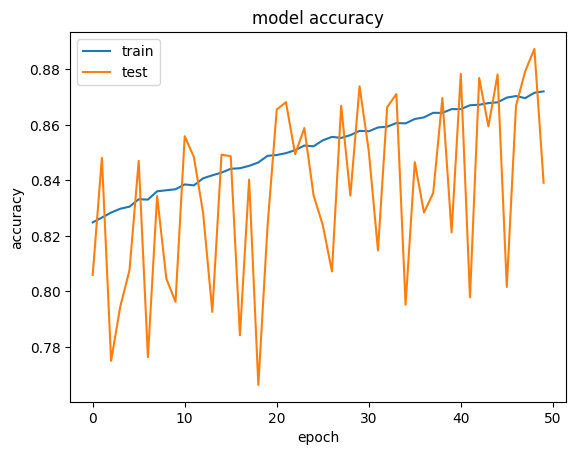

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
history = cnn_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

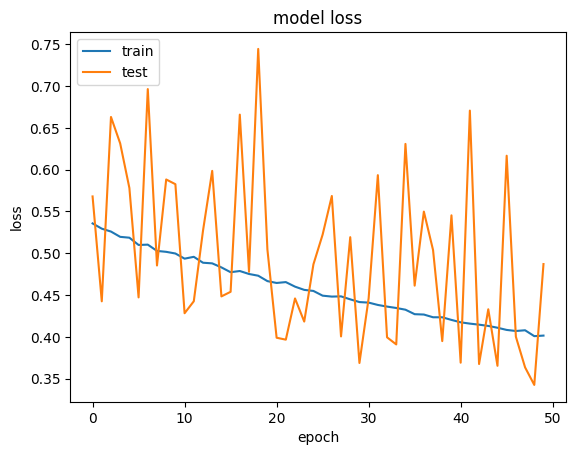

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

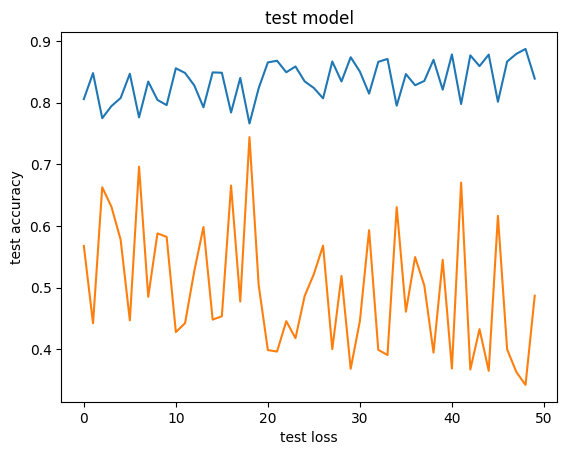

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

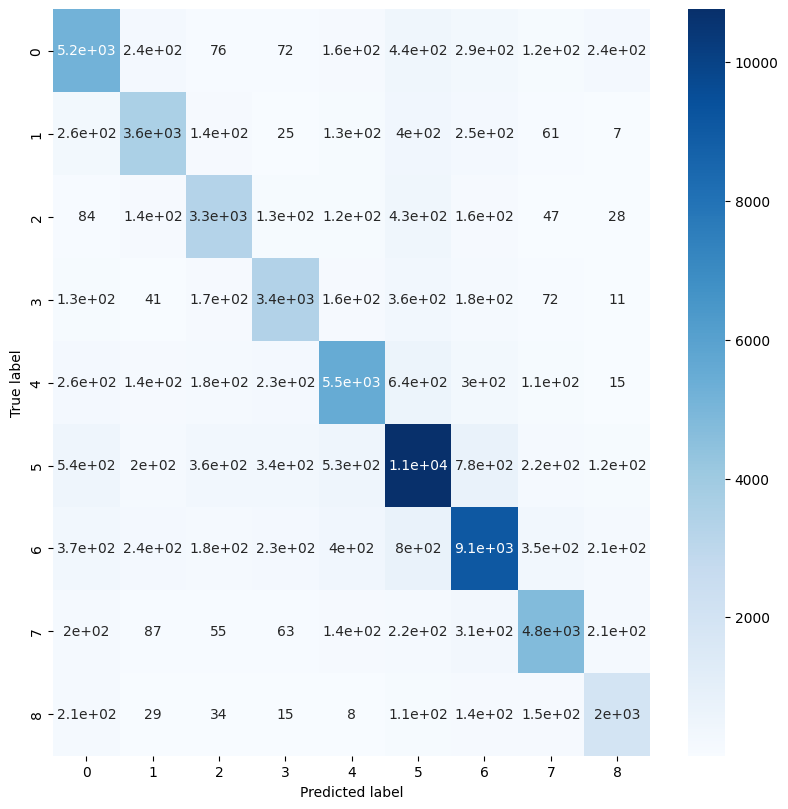

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = cnn_model.predict(X_test)

y_test1=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred,axis=1)
cmatrix=confusion_matrix(y_test1, y_pred)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###CNN-Transformer based model

Note: This code is under development

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Input
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.feed_forward = Sequential([
            Dense(embed_dim * 4, activation='relu'),
            Dense(embed_dim)
        ])
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))
        ffn_output = self.feed_forward(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output))

In [ ]:
from tensorflow.keras.layers import Input, Reshape

input_shape = (x_train.shape[1], 1)
inputs = Input(shape=input_shape)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=(2))(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=(2))(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=(2))(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=(2))(x)

x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=(2))(x)

# Flatten the output of the CNN
x = Flatten()(x)

# Reshape for transformer input (batch size must be included later during training)
# Assuming embed_dim is defined as before.
num_heads = 4   # Number of attention heads
embed_dim = 64  # Dimension of embedding vector
num_classes = 10


# Reshape x to (batch_size, sequence_length, embed_dim)
# Here we assume sequence_length is derived from previous layers.
sequence_length = x.shape[1] // embed_dim  # Adjust based on your architecture
reshaped_x = Reshape((-1, sequence_length, embed_dim))(x)

transformer_block = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)(reshaped_x)

from tensorflow.keras.layers import Dense

outputs = Dense(num_classes, activation='softmax')(transformer_block)

# Create Model
ct_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
ct_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define parameters for training
batch_size = 32
epochs = 50

# Train the model
history = ct_model.fit(x_train,
                        y_train,
                        validation_data=(X_val, Y_val),
                        batch_size=batch_size,
                        epochs=epochs)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(32, 10), output.shape=(32, 1, 2, 10)

###Training LSTM model for the valence predection

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import LSTM

batch_size = 256
num_classes = 10
epochs = 20
input_shape=(x_train.shape[1], 1)

In [ ]:
lstm_model = Sequential()

lstm_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
lstm_model.add(Dropout(0.6))
lstm_model.add(LSTM(units = 256, return_sequences = True))
lstm_model.add(Dropout(0.6))
lstm_model.add(LSTM(units = 64, return_sequences = True))
lstm_model.add(Dropout(0.6))
lstm_model.add(LSTM(units = 64, return_sequences = True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(units = 32))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(units = 32))
lstm_model.add(Activation('relu'))
lstm_model.add(Dense(units = 16))
lstm_model.add(Activation('relu'))
lstm_model.add(Dense(units = 16))
lstm_model.add(Activation('relu'))

lstm_model.add(Dense(units = num_classes))
lstm_model.add(Activation('softmax'))
lstm_model.compile(optimizer ="adam", loss =keras.losses.categorical_crossentropy,metrics=["accuracy"])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 176, 256)            │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 176, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 176, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 176, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 176, 64)             │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 176, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 176, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 176, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 788,074 (3.01 MB)

 Trainable params: 788,074 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = lstm_model.fit(x_train, y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_val, Y_val))

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1812 - loss: 2.1456 - val_accuracy: 0.2526 - val_loss: 1.9665
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.2557 - loss: 1.9644 - val_accuracy: 0.3086 - val_loss: 1.8347
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.3143 - loss: 1.8306 - val_accuracy: 0.3651 - val_loss: 1.6749
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.3563 - loss: 1.7155 - val_accuracy: 0.4042 - val_loss: 1.5821
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.3917 - loss: 1.6098 - val_accuracy: 0.4403 - val_loss: 1.5041
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.4360 - loss: 1.5056 - val_accuracy: 0.5077 - val_loss: 1.3196
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.4838 - loss: 1.3879 - val_accuracy: 0.5719 - val_loss: 1.1636
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.5316 - loss: 1

In [ ]:
# Save the model to a directory
lstm_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/lstm_model_v1.h5')

In [ ]:
score = lstm_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# For three subjects:
# Test loss: 0.4250689148902893
# Test accuracy: 0.8852459192276001

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9664 - loss: 0.1075
Test loss: 0.11145991086959839
Test accuracy: 0.9641393423080444


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


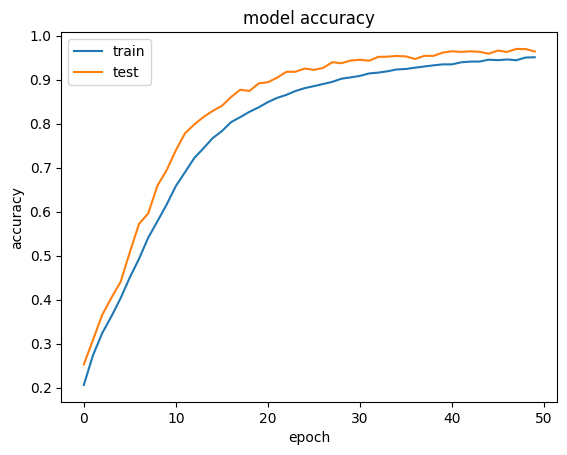

In [ ]:
import matplotlib.pyplot as plt
print(lstm_history.history.keys())

# summarize history for accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


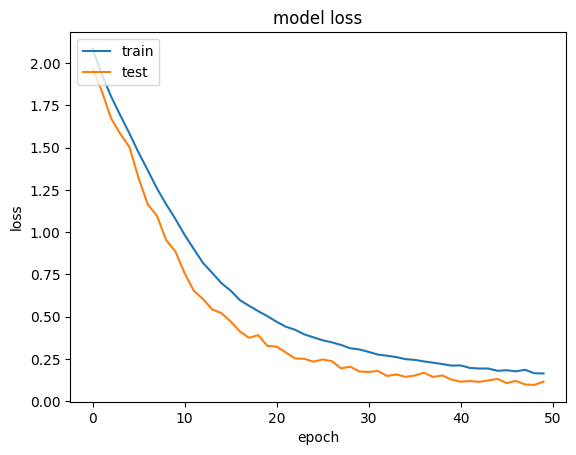

In [ ]:
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

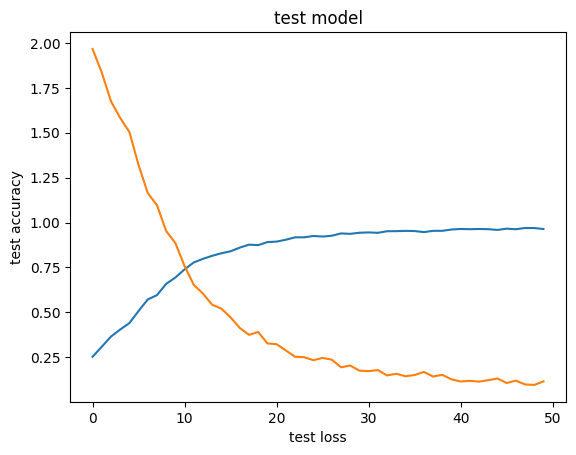

In [ ]:
plt.plot(lstm_history.history['val_accuracy'])
plt.plot(lstm_history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


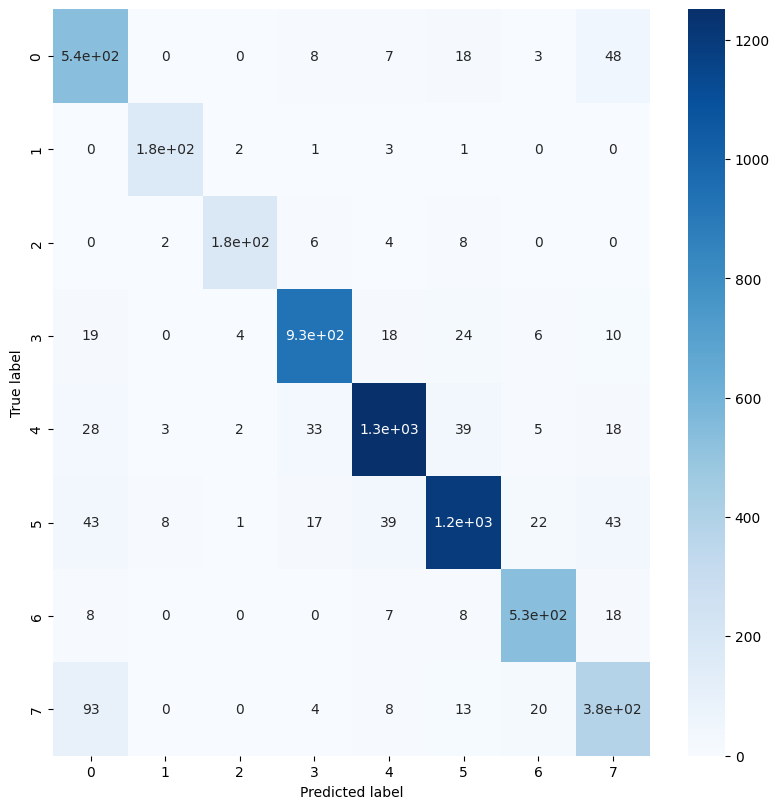

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

y_pred = lstm_model.predict(X_test)
Y_test=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred, axis=1)
cmatrix=confusion_matrix(Y_test, y_pred)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###Training GRU model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense, GRU, Bidirectional
from keras.regularizers import l2

batch_size = 256
num_classes = 10
epochs = 20
input_shape=(x_train.shape[1], 1)

In [ ]:
gru_model = Sequential()

gru_model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
gru_model.add(Dropout(0.6))

gru_model.add(GRU(units=256, return_sequences=True))
gru_model.add(Dropout(0.6))

gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.6))

gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.4))

gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.4))

gru_model.add(Dense(units=32))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=16))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=16))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=num_classes))
gru_model.add(Activation('softmax'))

gru_model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
gru_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 176, 256)            │         100,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 176, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 176, 256)            │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 176, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 176, 64)             │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 176, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 176, 64)             │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 176, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,578 (2.26 MB)

 Trainable params: 593,578 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_history = gru_model.fit(x_train, y_train,epochs=apochs,batch_size=batch_size,verbose=1,validation_data=(X_val, Y_val))

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.1872 - loss: 2.1540 - val_accuracy: 0.2806 - val_loss: 1.9251
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.2920 - loss: 1.8976 - val_accuracy: 0.3509 - val_loss: 1.7321
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.3626 - loss: 1.7241 - val_accuracy: 0.4573 - val_loss: 1.4769
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.4409 - loss: 1.5328 - val_accuracy: 0.5334 - val_loss: 1.2782
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.4957 - loss: 1.3768 - val_accuracy: 0.6066 - val_loss: 1.0908
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.5495 - loss: 1.2363 - val_accuracy: 0.6605 - val_loss: 0.9473
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.5996 - loss: 1.1212 - val_accuracy: 0.6980 - val_loss: 0.8385
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.6457 - loss: 1

In [ ]:
score = gru_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# For three subjects:
# Test loss: 0.45923101902008057
# Test accuracy: 0.8748292326927185

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9719 - loss: 0.0934
Test loss: 0.09702271968126297
Test accuracy: 0.9702869057655334


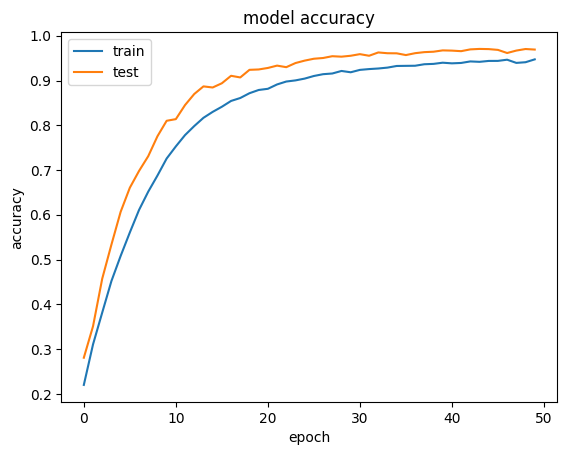

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

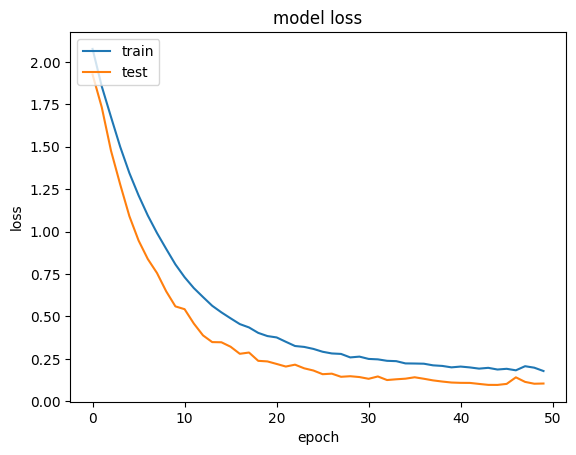

In [ ]:
# summarize history for loss
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

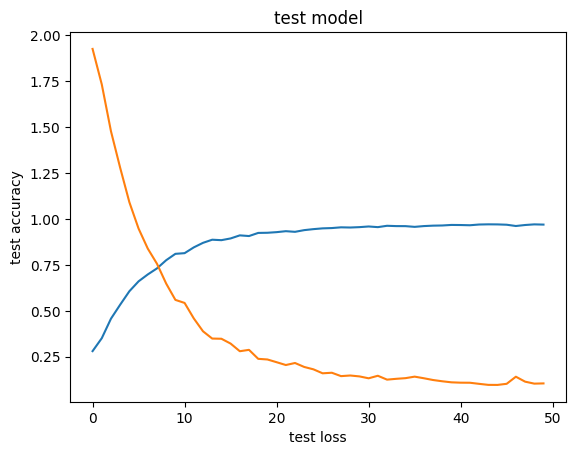

In [ ]:
plt.plot(gru_history.history['val_accuracy'])
plt.plot(gru_history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

###CNN, LSTM and GRU models performance comparison

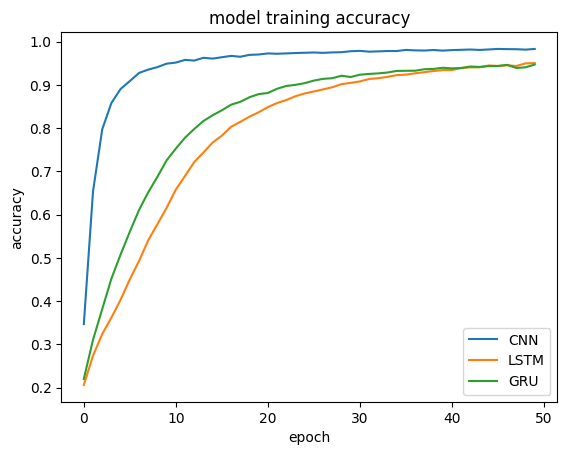

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(lstm_history.history['accuracy'])
plt.plot(gru_history.history['accuracy'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','LSTM', 'GRU'], loc='lower right')
plt.show()

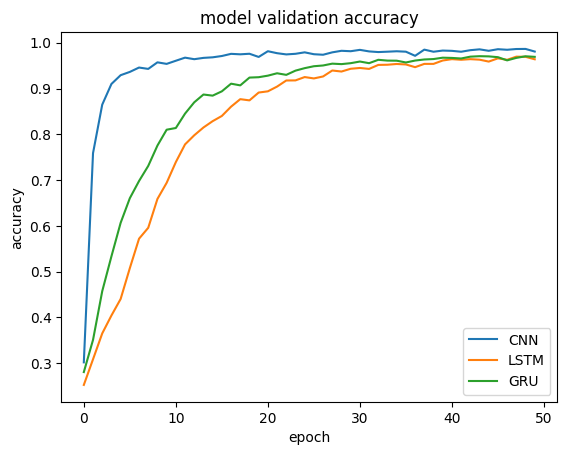

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
plt.plot(cnn_history.history['val_accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','LSTM', 'GRU'], loc='lower right')
plt.show()

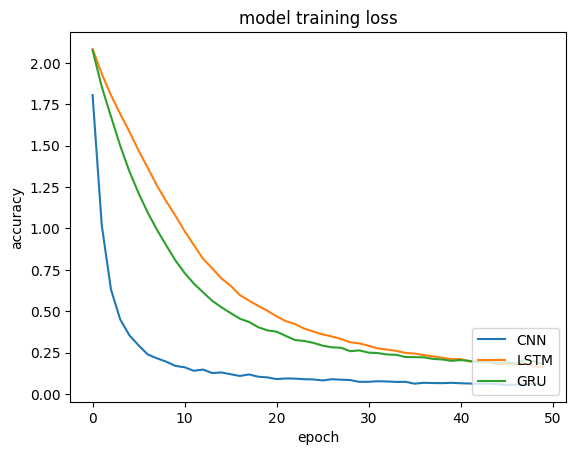

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
plt.plot(cnn_history.history['loss'])
plt.plot(lstm_history.history['loss'])
plt.plot(gru_history.history['loss'])
plt.title('model training loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','LSTM', 'GRU'], loc='lower right')
plt.show()

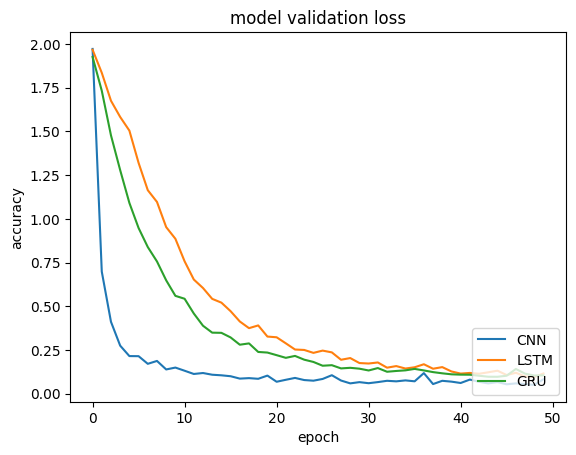

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
plt.plot(cnn_history.history['val_loss'])
plt.plot(lstm_history.history['val_loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN','LSTM', 'GRU'], loc='lower right')
plt.show()

##Extracting the fear releated data from the DEAP dataset
<p>This procedure involves the same as the data preprocessed to train the backbone model.</p>
<p>The extra thing the we gona do is to add the class labels based on the different fear level on the basis of arousal, valence, dominance, liking</p>

In [ ]:
# This only includes the 14 eeg channels and other 8 pps
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data"

# This includes 32 eeg channels and other 8 pps
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data/full_channels"

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
# channel = [i for i in range(1,33)]
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['1','2','3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']
subjectList = [str(i) for i in range(29, 33)]
print(channel)
print(subjectList)
#List of subjects

[1, 2, 3, 4, 6, 11, 13, 17, 19, 20, 21, 25, 29, 31]
['29', '30', '31', '32']


###Extracting the data

In [ ]:
#The following code is to extract the fear data and features
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    '''
    r - relax
    l - low fear
    m - medium fear
    h - high fear
    '''
    print("processing subject: ", sub)
    meta = []
    label_sub = []
    with open(file_loc + "/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1
        print("")
        for i in range (0,40):
            # print(i)
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            if labels[0]>=7 and  labels[0]<=9 and labels[1]>=1 and  labels[1]<3 and labels[2]>=7 and  labels[2]<=9:
                print("R", end = "")
                while start + window_size < data.shape[1]:
                    meta_array = []
                    meta_data = [] #meta vector for analysis
                    for j in channel:
                        X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                        Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                        meta_data = meta_data + list(Y[0])

                    # PPS Signals - Time-domain features (e.g., mean, variance, etc.)
                    for j in pps:
                        X = data[j][start: start + window_size]  # Slice PPS data over the same window
                        # Example: You can calculate mean and variance from the PPS signal for this window
                        pps_mean = np.mean(X)
                        pps_var = np.var(X)

                        # Add these PPS features to the meta_data vector
                        meta_data.append(pps_mean)
                        meta_data.append(pps_var)

                    meta_array.append(np.array(meta_data))
                    # meta_array.append((labels))
                    label_sub.append(np.array([[1., 0., 0., 0.]]))
                    meta.append(np.array(meta_array))
                    start = start + step_size
            elif labels[0]>=5 and  labels[0]<7 and labels[1]>=3 and  labels[1]<5 and labels[2]>=5 and  labels[2]<7:
                print("L", end = "")
                while start + window_size < data.shape[1]:
                    meta_array = []
                    meta_data = [] #meta vector for analysis
                    for j in channel:
                        X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                        Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                        meta_data = meta_data + list(Y[0])

                    # PPS Signals - Time-domain features (e.g., mean, variance, etc.)
                    for j in pps:
                        X = data[j][start: start + window_size]  # Slice PPS data over the same window
                        # Example: You can calculate mean and variance from the PPS signal for this window
                        pps_mean = np.mean(X)
                        pps_var = np.var(X)

                        # Add these PPS features to the meta_data vector
                        meta_data.append(pps_mean)
                        meta_data.append(pps_var)

                    meta_array.append(np.array(meta_data))
                    # meta_array.append((labels))
                    label_sub.append(np.array([[0., 1., 0., 0.]]))
                    meta.append(np.array(meta_array))
                    start = start + step_size
            elif labels[0]>=3 and  labels[0]<5 and labels[1]>=5 and  labels[1]<7 and labels[2]>=3 and  labels[2]<5:
                print("M", end = "")
                while start + window_size < data.shape[1]:
                    meta_array = []
                    meta_data = [] #meta vector for analysis
                    for j in channel:
                        X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                        Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                        meta_data = meta_data + list(Y[0])

                    # PPS Signals - Time-domain features (e.g., mean, variance, etc.)
                    for j in pps:
                        X = data[j][start: start + window_size]  # Slice PPS data over the same window
                        # Example: You can calculate mean and variance from the PPS signal for this window
                        pps_mean = np.mean(X)
                        pps_var = np.var(X)

                        # Add these PPS features to the meta_data vector
                        meta_data.append(pps_mean)
                        meta_data.append(pps_var)

                    meta_array.append(np.array(meta_data))
                    # meta_array.append((labels))
                    label_sub.append(np.array([[0., 0., 1., 0.]]))
                    meta.append(np.array(meta_array))
                    start = start + step_size
            elif labels[0]>=1 and  labels[0]<3 and labels[1]>=7 and  labels[1]<=9 and labels[2]>=1 and  labels[2]<3:
                print("H", end = "")
                while start + window_size < data.shape[1]:
                    meta_array = []
                    meta_data = [] #meta vector for analysis
                    for j in channel:
                        X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                        Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                        meta_data = meta_data + list(Y[0])

                    # PPS Signals - Time-domain features (e.g., mean, variance, etc.)
                    for j in pps:
                        X = data[j][start: start + window_size]  # Slice PPS data over the same window
                        # Example: You can calculate mean and variance from the PPS signal for this window
                        pps_mean = np.mean(X)
                        pps_var = np.var(X)

                        # Add these PPS features to the meta_data vector
                        meta_data.append(pps_mean)
                        meta_data.append(pps_var)

                    meta_array.append(np.array(meta_data))
                    # meta_array.append((labels))
                    label_sub.append(np.array([[0., 0., 0., 1.]]))
                    meta.append(np.array(meta_array))
                    start = start + step_size
            else:
                print("|", end = "")

        meta = np.array(meta)
        label_sub = np.array(label_sub)
        np.save(fear_dir + '/s' + sub, meta, allow_pickle=True, fix_imports=True)
        np.save(fear_dir + '/s_label' + sub, label_sub, allow_pickle=True, fix_imports=True)
        print("\nfiles saved", meta.shape, label_sub.shape)


for subject in subjectList:
    FFT_Processing (subject, channel, band, window_size, step_size, sample_rate)

processing subject:  1

|||||||||||||||||||||R||||||||||||||||||
files saved (488, 1, 86) (488, 1, 4)
processing subject:  2

|||||L||||R|||||||||||||||M||H|H||||HH||
files saved (3416, 1, 86) (3416, 1, 4)
processing subject:  3

||||L|L|||||||||||||M||||||||||L|||||||L
files saved (2440, 1, 86) (2440, 1, 4)
processing subject:  4

||||M|||L|||||||||||||||||||||||||||||||
files saved (976, 1, 86) (976, 1, 4)
processing subject:  5

|||||||||||||||||||||||M||||||||||||||||
files saved (488, 1, 86) (488, 1, 4)
processing subject:  6

|||||||||||||||||||L|||||L||M|||||M|MM||
files saved (2928, 1, 86) (2928, 1, 4)
processing subject:  7

|||||||||||L|||M|||||||H||||||||||||||||
files saved (1464, 1, 86) (1464, 1, 4)
processing subject:  8

|||||||||||||L||L||L|||||||L|||||||||||M
files saved (2440, 1, 86) (2440, 1, 4)
processing subject:  9

|||||||||||||||||||L||||L||H|M|M||||||M|
files saved (2928, 1, 86) (2928, 1, 4)
processing subject:  10

||L||||L||||||||||||||||||||||M|||||||||
file

In [ ]:
#This code is to split dataset into training and testing

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(fear_dir + "/s" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          # label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          # label_training.append(sub[i][1])

for subjects in subjectList:

    with open(fear_dir + "/s_label" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          # data_testing.append(sub[i][0])
          label_testing.append(sub[i][0])
        else:
          # data_training.append(sub[i][0])
          label_training.append(sub[i][0])

np.save(fear_dir + '/r_data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(fear_dir + '/r_label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(fear_dir + '/r_data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(fear_dir + '/r_label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (48400, 86) (48400, 4)
testing dataset: (12112, 86) (12112, 4)


###Execute the code

In [ ]:
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data/full_channels"
with open(fear_dir + '/f_data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(fear_dir + '/f_label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

print(X.shape)
print(Y.shape)
# X = normalize(X)
# Reshape X to be a 2D array before normalization
X = normalize(X)
from keras.utils import to_categorical
x_train = np.array(X[:])
y_train = np.array(Y[:])
# y_train = to_categorical(Y)

print(X.shape)
print(x_train.shape)
print(y_train.shape)

(48400, 176)
(48400, 4)
(48400, 176)
(48400, 176)
(48400, 4)


In [ ]:
with open(fear_dir + '/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(fear_dir + '/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
x_test = np.array(M[:])
y_test = np.array(N[:])


print(x_test.shape)
print(y_test.shape)

(12112, 176)
(12112, 4)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
fx_train = scaler.fit_transform(x_train)
fx_test = scaler.fit_transform(x_test)
fx_train = fx_train.reshape(fx_train.shape[0],fx_train.shape[1], 1)
fx_test = fx_test.reshape(fx_test.shape[0],fx_test.shape[1], 1)
print(fx_train.shape)
print(fx_test.shape)
fy_test = y_test
fy_train = y_train

print('\n\n')

fX_test, fX_val, fY_test, fY_val = train_test_split(fx_test, fy_test, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
fX_test = np.array(fX_test)
fX_val = np.array(fX_val)
fY_test = np.array(fY_test)
fY_val = np.array(fY_val)

print("X_train shape", fx_train.shape)
print("X_test shape:", fX_test.shape)
print("X_val shape:", fX_val.shape)
print("Y_train shape", fy_train.shape)
print("Y_test shape:", fY_test.shape)
print("Y_val shape:", fY_val.shape)

(48400, 176, 1)
(12112, 176, 1)



X_train shape (48400, 176, 1)
X_test shape: (6056, 176, 1)
X_val shape: (6056, 176, 1)
Y_train shape (48400, 4)
Y_test shape: (6056, 4)
Y_val shape: (6056, 4)


##Fine Tuning model for Fear Level Classification

###Fine tuning CNN Teacher model

In [ ]:
# Load the model from the HDF5 file
# cnn_model_v1 - trained on 32 eeg and 8 pps
# cnn_model_v2 - trained on 14 eeg and 8 pps
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_v1.keras')


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

batch_size = 256
# Assume 'model' is your pre-trained backbone model
# Define the input shape
input_shape=(fx_train.shape[1], 1)

# Create an Input layer with the correct shape
new_input = Input(shape=input_shape)

# Connect the new input to the first layer of your existing model
x = cnn_model.layers[0](new_input)

# Connect the remaining layers of your existing model
for layer in cnn_model.layers[1:-1]:
    x = layer(x)

# Modify the last layer for 4-class fear detection
# model.layers[-1].trainable = False  # Freeze the previous final layer - Not needed as new output is defined
new_output = Dense(4, activation='softmax', name='fear_output')(x)  # New output layer for 4 classes

# Create a new model with the modified output layer
fine_tuned_cnn_model = Model(inputs=new_input, outputs=new_output)

# Recompile the model for fear detection task
fine_tuned_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
ft_cnn_history = fine_tuned_cnn_model.fit(fx_train, fy_train,
                               batch_size=batch_size,
                               epochs=50,
                               verbose=1,
                               validation_data=(fX_val, fY_val))

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.4331 - loss: 1.5616 - val_accuracy: 0.7299 - val_loss: 0.6634
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7143 - loss: 0.6939 - val_accuracy: 0.8633 - val_loss: 0.3824
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8377 - loss: 0.4412 - val_accuracy: 0.9122 - val_loss: 0.2411
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8944 - loss: 0.3076 - val_accuracy: 0.9412 - val_loss: 0.1668
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9267 - loss: 0.2238 - val_accuracy: 0.9590 - val_loss: 0.1189
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9366 - loss: 0.1921 - val_accuracy: 0.9690 - val_loss: 0.0919
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9544 - loss: 0.1406 - val_accuracy: 0.9685 - val_loss: 0.0867
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9614 - loss: 0.1229 - val_acc

In [ ]:
fine_tuned_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')

###Evaluating the Model

In [ ]:
fine_tuned_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')

In [ ]:
# list all data in history
# print(ft_cnn_history.history.keys())
score = fine_tuned_cnn_model.evaluate(fX_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Test loss: 0.02783295325934887
# Test accuracy: 0.9925693273544312

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9931 - loss: 0.0198
Test loss: 0.021610459312796593
Test accuracy: 0.993229866027832


###Fine-Tuning LSTM Backbone model

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Assume 'model' is your pre-trained backbone model
input_shape=(fx_train.shape[1], 1)  # Define the input shape

# Create an Input layer with the correct shape
new_input = Input(shape=input_shape)

# Connect the new input to the first layer of your existing model
x = lstm_model.layers[0](new_input)

# Connect the remaining layers of your existing model
for layer in lstm_model.layers[1:-1]:
    x = layer(x)

# Modify the last layer for 4-class fear detection
# model.layers[-1].trainable = False  # Freeze the previous final layer - Not needed as new output is defined
new_output = Dense(4, activation='softmax')(x)  # New output layer for 4 classes

# Create a new model with the modified output layer
fine_tuned_lstm_model = Model(inputs=new_input, outputs=new_output)

# Recompile the model for fear detection task
fine_tuned_lstm_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
ft_lstm_history = fine_tuned_lstm_model.fit(fx_train, y_train,
                               batch_size=batch_size,
                               epochs=20,
                               verbose=1,
                               validation_data=(fX_val, fY_val))

Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.2026 - loss: 7.3465 - val_accuracy: 0.3945 - val_loss: 1.1383
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4445 - loss: 1.1192 - val_accuracy: 0.7261 - val_loss: 0.7039
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.6672 - loss: 0.7833 - val_accuracy: 0.7744 - val_loss: 0.5593
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.7345 - loss: 0.6512 - val_accuracy: 0.8088 - val_loss: 0.4820
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7701 - loss: 0.5747 - val_accuracy: 0.8027 - val_loss: 0.4641
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7937 - loss: 0.5253 - val_accuracy: 0.8461 - val_loss: 0.3860
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8107 - loss: 0.4696 - val_accuracy: 0.8448 - val_loss: 0.3886
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.8267 - loss: 0.4422 - 

In [ ]:
# list all data in history
print(ft_lstm_history.history.keys())
score = fine_tuned_lstm_model.evaluate(fX_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9070 - loss: 0.2361
Test loss: 0.23854614794254303
Test accuracy: 0.904557466506958


###Fine Tuning GRU model

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Assume 'model' is your pre-trained backbone model
input_shape=(fx_train.shape[1], 1)  # Define the input shape

# Create an Input layer with the correct shape
new_input = Input(shape=input_shape)

# Connect the new input to the first layer of your existing model
x = gru_model.layers[0](new_input)

# Connect the remaining layers of your existing model
for layer in gru_model.layers[1:-1]:
    x = layer(x)

# Modify the last layer for 4-class fear detection
# model.layers[-1].trainable = False  # Freeze the previous final layer - Not needed as new output is defined
new_output = Dense(4, activation='softmax')(x)  # New output layer for 4 classes

# Create a new model with the modified output layer
fine_tuned_gru_model = Model(inputs=new_input, outputs=new_output)

# Recompile the model for fear detection task
fine_tuned_gru_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
ft_gru_history = fine_tuned_gru_model.fit(fx_train, fy_train,
                               batch_size=batch_size,
                               epochs=20,
                               verbose=1,
                               validation_data=(fX_val, fY_val))

Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4880 - loss: 1.4130 - val_accuracy: 0.7531 - val_loss: 0.5796
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7505 - loss: 0.5945 - val_accuracy: 0.8068 - val_loss: 0.4527
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7957 - loss: 0.4929 - val_accuracy: 0.8400 - val_loss: 0.3793
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8293 - loss: 0.4094 - val_accuracy: 0.8699 - val_loss: 0.3090
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8374 - loss: 0.3899 - val_accuracy: 0.8838 - val_loss: 0.2778
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8525 - loss: 0.3491 - val_accuracy: 0.8882 - val_loss: 0.2677
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8690 - loss: 0.3157 - val_accuracy: 0.8905 - val_loss: 0.2611
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8705 - loss: 0.3124 - 

In [ ]:
# list all data in history
print(ft_gru_history.history.keys())
score = fine_tuned_gru_model.evaluate(fX_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8905 - loss: 0.2616
Test loss: 0.25811082124710083
Test accuracy: 0.8920079469680786


##Knowledge distillation for the fear level detection



<p>The testing result of all three model - CNN, LSTM, GRU</P>

<b>For 10 epochs:</b>
<ol>
  <li>Without distillation:
    <ul>
      <li>Test loss: 0.0836</li>
      <li>Test accuracy: 0.9679</li>
    </ul>
  </li>
  <li>With soft-targets:
    <ul>
      <li>Test loss: 0.1425</li>
      <li>Test accuracy: 0.9550</li>
    </ul>
  </li>
  <li>With custom-loss function:
    <ul>
      <li>Validation Accuracy: 0.9408</li>
      <li>Validation Loss: 0.0417</li>
    </ul>
  </li>
</ol>

<p><b>For 100 epochs:</b></p>
<ol>
  <li>Without distillation:
    <ul>
      <li>Test loss: 0.0388</li>
      <li>Test accuracy: 0.9877</li>
    </ul>
  </li>
  <li>With distillation:
    <ul>
      <li>Test loss: 0.0321</li>
      <li>Test accuracy: 0.9886</li>
    </ul>
  </li>
  <li>With custom loss function
    <ul>
      <li>Test Loss: 0.0306</li>
      <li>Test Accuracy: 0.9896</li>
    </ul>
  </li>
</ol>

###Consider the relevent channels to train the student model

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31]
batch_size = 256
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data"

# Get the last 16 columns - for pps
last_16_columns = np.arange(fx_train.shape[1] - 16, fx_train.shape[1])
new_channels = []

for i in channel:
  for j in range(5):
    new_channels.append(i*5+j)

print(new_channels)

# Concatenate the specified channels with the last 16 columns
columns_to_extract = np.concatenate((new_channels, last_16_columns))
print(columns_to_extract)

r_fx_train = fx_train[:, columns_to_extract]
r_fx_test = fX_test[:, columns_to_extract]
r_fx_val = fX_val[:, columns_to_extract]
print(r_fx_train.shape)
print(r_fx_test.shape)
print(r_fx_val.shape )

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 55, 56, 57, 58, 59, 65, 66, 67, 68, 69, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 125, 126, 127, 128, 129, 145, 146, 147, 148, 149, 155, 156, 157, 158, 159]
[  5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  30  31  32  33  34  55  56  57  58  59  65  66  67  68  69  85
  86  87  88  89  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 125 126 127 128 129 145 146 147 148 149 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175]
(48400, 86, 1)
(6056, 86, 1)
(6056, 86, 1)


####CNN student model for fear level classificatoin

In [ ]:
fine_tuned_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [ ]:
stud_cnn_model = Sequential()
input_shape=(r_fx_train.shape[1], 1)
stud_cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu',
                          input_shape=input_shape))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Flatten())
stud_cnn_model.add(Dense(64, activation='tanh'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(16, activation='relu'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(4, activation='softmax'))
stud_cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 86, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 86, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 43, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 43, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 21, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,588 (459.33 KB)

 Trainable params: 117,076 (457.33 KB)

 Non-trainable params: 512 (2.00 KB)

#### Without Knowledge Distillation

In [ ]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, fy_train,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(r_fx_val, fY_val))

In [ ]:
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_wkd.keras')

In [ ]:
print(stud_cnn_history.history.keys())
score = stud_cnn_model.evaluate(r_fx_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

####Using soft targets from teacher model

In [ ]:
soft_targets = fine_tuned_cnn_model.predict(fx_train)

# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, soft_targets,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(r_fx_val, fY_val))

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5376 - loss: 1.0527 - val_accuracy: 0.4757 - val_loss: 1.2590
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7496 - loss: 0.6124 - val_accuracy: 0.5355 - val_loss: 1.1670
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8174 - loss: 0.4662 - val_accuracy: 0.8415 - val_loss: 0.3884
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8591 - loss: 0.3628 - val_accuracy: 0.8760 - val_loss: 0.3105
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8824 - loss: 0.3115 - val_accuracy: 0.8971 - val_loss: 0.2745
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8911 - loss: 0.2894 - val_accuracy: 0.9138 - val_loss: 0.2205
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9144 - loss: 0.2279 - val_accuracy: 0.9199 - val_loss: 0.1932
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9204 - loss: 0.2081 - val_ac

In [ ]:
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_clf.keras')

In [ ]:
# list all data in history
print(stud_cnn_history.history.keys())
score = stud_cnn_model.evaluate(r_fx_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

####Setting custom loss function

In [ ]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence

# Assuming `r_fx_train`, `fy_train`, `fX_val`, and `fY_val` are numpy arrays
# Convert the numpy arrays into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((fx_train, fy_train))
val_dataset = tf.data.Dataset.from_tensor_slices((fX_val, fY_val))
test_dataset = tf.data.Dataset.from_tensor_slices((fX_test, fY_test))

# Shuffle and batch the training dataset
BATCH_SIZE = 256  # You can change this based on memory capacity and model requirements

# Prepare the training dataset with shuffling, batching, and prefetching for performance
train_dataset = train_dataset.shuffle(buffer_size=len(r_fx_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.experimental.AUTOTUNE)

# Prepare the validation dataset, batching only (no shuffle for validation)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Now, `train_dataset` and `val_dataset` are ready to be used in the training loop.


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy

# Define the loss function
def knowledge_distillation_loss(y_true, y_pred_student, teacher_model, X_batch, alpha=0.5, temperature=3.0):
    # Classification loss (student vs ground truth)
    classification_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    classification_loss = classification_loss_fn(y_true, y_pred_student)

    # Teacher predictions for the current batch
    y_pred_teacher = teacher_model(X_batch, training=False)

    # Distillation loss (student vs teacher predictions)
    distillation_loss_fn = tf.keras.losses.KLDivergence()
    distillation_loss = distillation_loss_fn(
        tf.nn.softmax(y_pred_teacher / temperature, axis=1),
        tf.nn.softmax(y_pred_student / temperature, axis=1)
    )

    # Combine losses
    combined_loss = alpha * classification_loss + (1 - alpha) * distillation_loss
    return combined_loss

# Define custom training loop
def train_model(student_model, teacher_model, train_dataset, val_dataset, epochs, optimizer, alpha=0.5, temperature=3.0):
    train_acc_metric = CategoricalAccuracy()
    val_acc_metric = CategoricalAccuracy()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training loop
        for step, (X_batch_train, y_batch_train) in enumerate(train_dataset):
            print("|", end="")
            with tf.GradientTape() as tape:
                # Student predictions for the current batch
                columns_to_extract_tf = tf.constant(columns_to_extract, dtype=tf.int32)
                batch_train = tf.gather(X_batch_train, columns_to_extract_tf, axis=1)
                y_pred_student = student_model(batch_train, training=True)

                # Calculate the loss
                loss_value = knowledge_distillation_loss(y_batch_train, y_pred_student, teacher_model, X_batch_train, alpha, temperature)

            # Compute gradients and apply them to update weights
            grads = tape.gradient(loss_value, student_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, student_model.trainable_weights))

            # Update training accuracy
            train_acc_metric.update_state(y_batch_train, y_pred_student)

        # Compute training metrics
        train_acc = train_acc_metric.result()
        print(f"\nTraining Accuracy: {train_acc:.4f}")

        # Validation loop
        for X_batch_val, y_batch_val in val_dataset:
            columns_to_extract_tf = tf.constant(columns_to_extract, dtype=tf.int32)
            batch_val = tf.gather(X_batch_val, columns_to_extract_tf, axis=1)
            y_pred_val = student_model(batch_val, training=False)
            val_acc_metric.update_state(y_batch_val, y_pred_val)

        val_acc = val_acc_metric.result()
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Calculate validation loss (without gradients)
        total_val_loss = 0
        for X_batch_val, y_batch_val in val_dataset:
            columns_to_extract_tf = tf.constant(columns_to_extract, dtype=tf.int32)
            batch_val = tf.gather(X_batch_val, columns_to_extract_tf, axis=1)
            y_pred_val = student_model(batch_val, training=False)
            val_loss_value = knowledge_distillation_loss(y_batch_val, y_pred_val, teacher_model, X_batch_val, alpha, temperature)
            total_val_loss += val_loss_value

        val_loss_value = total_val_loss / len(val_dataset)

        print(f"Epoch {epoch + 1} Loss: {loss_value:.4f}, Validation Loss: {val_loss_value:.4f}")

# Example usage
# Assuming `train_dataset` and `val_dataset` are already defined, and models are built

optimizer = tf.keras.optimizers.Adam()
epochs = 50

# Call the training function
train_model(stud_cnn_model, fine_tuned_cnn_model, train_dataset, val_dataset, epochs, optimizer, alpha=0.5, temperature=3.0)



Epoch 1/50
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Training Accuracy: 0.9830
Validation Accuracy: 0.9840
Epoch 1 Loss: 0.0360, Validation Loss: 0.0233

Epoch 2/50
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Training Accuracy: 0.9837
Validation Accuracy: 0.9827
Epoch 2 Loss: 0.0122, Validation Loss: 0.0275

Epoch 3/50
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Training Accuracy: 0.9834
Validation Accuracy: 0.9852
Epoch 3 Loss: 0.0342, Validation Loss: 0.0154

Epoch 4/50
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
def test_model(student_model, test_dataset):
    test_acc_metric = CategoricalAccuracy()
    total_test_loss = 0
    classification_loss_fn = CategoricalCrossentropy()

    for X_batch_test, y_batch_test in test_dataset:
        columns_to_extract_tf = tf.constant(columns_to_extract, dtype=tf.int32)
        batch_test = tf.gather(X_batch_test, columns_to_extract_tf, axis=1)

        # Student predictions for the current batch
        y_pred_student = student_model(batch_test, training=False)

        # Update test accuracy
        test_acc_metric.update_state(y_batch_test, y_pred_student)

    test_acc = test_acc_metric.result()
    print(f"Test Accuracy: {test_acc:.4f}")

    # Calculate test loss (without gradients)
    for X_batch_test, y_batch_test in test_dataset:
        columns_to_extract_tf = tf.constant(columns_to_extract, dtype=tf.int32)
        batch_test = tf.gather(X_batch_test, columns_to_extract_tf, axis=1)

        y_pred_student = student_model(batch_test, training=False)
        # test_loss_value = knowledge_distillation_loss(y_batch_test, y_pred_student,y_pred_teacher = None, alpha=0.5, temperature=3.0)

        test_loss_value = classification_loss_fn(y_batch_test, y_pred_student)
        total_test_loss += test_loss_value

    test_loss_value = total_test_loss / len(test_dataset)
    print(f"Test Loss: {test_loss_value:.4f}")

# Example usage
# Assuming `test_dataset` is already defined
test_model(stud_cnn_model, test_dataset)


Test Accuracy: 0.9896
Test Loss: 0.0306


## Knowledge Distillation w.r.t DEAP and ASCERTAIN dataset

<p>ASCERTAIN uses <b>single dry-electrode EEG sensor</b> to cover the frontal lobe to get the EEG output. Common channels between DEAP and ASCERTAIN dataset are:</p>
<ul>
<li>FP1 (Frontopolar Left) – Frontal lobe activity (emotional processing).</li>

<li>FP2 (Frontopolar Right) – Frontal lobe activity (emotional processing).</li>

<li>AF3 (Left Frontal) – Cognitive workload, attention.</li>

<li>AF4 (Right Frontal) – Cognitive workload, attention.</li>

<li>F3 (Left Dorsolateral Prefrontal Cortex) – Emotional regulation.</li>

<li>F4 (Right Dorsolateral Prefrontal Cortex) – Emotional regulation.</li>

<li>EOG (Electrooculography) – Vertical Eye Blinks (measures blink rate/strength).</li>

<li>EOG (Electrooculography) – Horizontal Eye Movements (if applicable).</li>
</ul>

<p>The channels to be considered for the knowledge3 distillation as follows</p>
<ul>
<li>FP1 - 1</li>
<li>FP2 - 17</li>
<li>AF3 - 2</li>
<li>AF4 - 18</li>
<li>F3 - 3</li>
<li>F4 - 20</li>
</ul>
Additionally,
<ul>
<li>GSR</li>
</ul>

In [ ]:
channel = [0,1,2,16,17,19]
batch_size = 256
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data"

new_channels = []

for i in channel:
  for j in range(5):
    new_channels.append(i*5+j)

# Append the GSR channels of mean and std
new_channels.append(168)
new_channels.append(169)
print(new_channels)

# Concatenate the specified channels with the last 16 columns
columns_to_extract = new_channels

r_fx_train = fx_train[:, columns_to_extract]
r_fx_test = fX_test[:, columns_to_extract]
r_fx_val = fX_val[:, columns_to_extract]
print(r_fx_train.shape)
print(r_fx_test.shape)
print(r_fx_val.shape )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99, 168, 169]
(48400, 32, 1)
(6056, 32, 1)
(6056, 32, 1)


In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

stud_cnn_model = Sequential()
input_shape=(r_fx_train.shape[1], 1)
stud_cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu',
                          input_shape=input_shape))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Flatten())
stud_cnn_model.add(Dense(64, activation='tanh'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(16, activation='relu'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(4, activation='softmax'))
stud_cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 32, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 16, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,524 (459.08 KB)

 Trainable params: 117,012 (457.08 KB)

 Non-trainable params: 512 (2.00 KB)

###Without Knowledge Distillation

In [ ]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, fy_train,
                               batch_size=batch_size,
                               epochs=10,
                               verbose=1,
                               validation_data=(r_fx_val, fY_val))

# rf - refined
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_wkd.keras')

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.4897 - loss: 1.1002 - val_accuracy: 0.4759 - val_loss: 1.2028
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.6024 - loss: 0.8712 - val_accuracy: 0.5215 - val_loss: 1.1943
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.6481 - loss: 0.7876 - val_accuracy: 0.6448 - val_loss: 0.8115
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.6836 - loss: 0.7118 - val_accuracy: 0.7231 - val_loss: 0.6323
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.6976 - loss: 0.6741 - val_accuracy: 0.7033 - val_loss: 0.7308
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7146 - loss: 0.6352 - val_accuracy: 0.7356 - val_loss: 0.6885
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7222 - loss: 0.6171 - val_accuracy: 0.7581 - val_loss: 0.5452
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.7416 - loss: 0.5834 - 

In [ ]:
print(stud_cnn_history.history.keys())
score = stud_cnn_model.evaluate(r_fx_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7854 - loss: 0.5037
Test loss: 0.5034892559051514
Test accuracy: 0.780878484249115


###Using Soft-targets

In [ ]:
fine_tuned_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')

In [ ]:
soft_targets = fine_tuned_cnn_model.predict(fx_train)

# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, soft_targets,
                               batch_size=batch_size,
                               epochs=10,
                               verbose=1,
                               validation_data=(r_fx_val, fY_val))
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_kd.keras')

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step
Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.4492 - loss: 1.4289 - val_accuracy: 0.5324 - val_loss: 0.9634
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5231 - loss: 0.9943 - val_accuracy: 0.6146 - val_loss: 0.8703
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.5786 - loss: 0.9115 - val_accuracy: 0.6103 - val_loss: 0.8526
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6012 - loss: 0.8618 - val_accuracy: 0.6768 - val_loss: 0.7353
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6322 - loss: 0.8018 - val_accuracy: 0.6846 - val_loss: 0.8450
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6610 - loss: 0.7608 - val_accuracy: 0.6948 - val_loss: 0.6965
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.6798 - loss: 0.7269 - val_accuracy: 0.7427 - val_loss: 0.6102
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 7

In [ ]:
stud_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_kd.keras')
# list all data in history
# print(stud_cnn_history.history.keys())
score = stud_cnn_model.evaluate(r_fx_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7583 - loss: 0.5737
Test loss: 0.5690513849258423
Test accuracy: 0.7620541453361511


##DECAF dataset

<ol>
<li>This dataset has raw data, pre-processed data and feature extracted data, now we currently work in the feature extracted data</li>
<li>DECAF has recordings for both music amd movie, we only focus on the movie since DEAP has only video recordings</li>
<li>The dataset is recorded with <b>30 participants, 36 movie clips and 40 one-min music clips</b></li>
<li>Dataset has the following recorded signals:
<ul>
<li>ECG - electrocardiography</li>
<li>EMG - trapezius electromyography</li>
<li>EOG - horizontal electrooculography</li>
<li>FMU - Facial Motion Unit</li>
<li>MCA - multimedia content analysis</li>
<li>MEG DCT - magnetoencephalography Discrete Cosine Transformer</li>
<li>MEG DEAP</li>
</ul>
</li>
<li>Similar to DEAP dataset, we have <b>Aurosal, Valence, Dominance and Familiarity</b></li>
</ol>

<p>Both DEAP and DECAF has hEOG and tEMG signals as common</p>
DECAF - feature-Extraction:

<h3>hEOG feature:</h3>
extract eye movement
information, we low-pass filtered the signal with
5 Hz cut off, and then used wavelet transform
to extract power spectral density (PSD) in 0-2 Hz
range with a frequency resolution of 0.2 Hz, and
temporal resolution of 50ms. Then for each second,
we averaged the PSD values over frequency ranges of
<b>{[0, 0.1), [0.1, 0.2), [0.2, 0.3), [0.3, 0.4), [0.4, 0.6), [0.6, 1.0),
[1.0, 1.5), [1.5, 2)}</b>. Therefore, we obtained 8 features
per second to describe eye movements.

For each each feature, we extrach - mean, std, skewness, kurtosis, %values>mean+std, %values < mean-std <br>
so, totally we get 11x6(with facial) = 66
and 8x6 = 48<br>
we can use only mean, std and skewness
then we have <b>8x3 = 24</b> features
<hr>
<h3>tEMG feature:</h3>
EMG signal consists
of two components: (1) Heart activities such as heart
beats can be mainly inferred from the 0-45 Hz range,
and (2) Trapezius EMG can be obtained from the
{[55, 95), [105, 145)} range.

Heart activities: We low-passed the signal to
within 45 Hz, and used wavelet transform to

extract the PSD map with frequency and tem-
poral resolution of 0.2 Hz and 50 ms respec-
tively. Per second and trial, we computed the

mean PSD over the following frequency bands:
<b>{[0, 0.5), [0.5, 1.5), [1.5, 2.5), [2.5, 3.5), [3.5, 5.0), [5.0, 10),
[10, 15),(15, 25), [25, 45)}</b>, to describe heart activities
when the ECG signal was unavailable.

Muscle activities: We band-passed the EMG signal
between 55-145 Hz and employed wavelet transform
to extract the PSD map with frequency resolution of 1
Hz, and temporal resolution of 500 ms. Per each sec-
ond and trial, we computed two values corresponding
to mean PSD over the <b>{[55, 95), [105, 145)}</b> frequency
bands to characterize trapezius muscle activities, and
aforementioned statistical measures over the final 50 seconds

For each each feature, we extrach - mean, std, skewness, kurtosis, %values>mean+std, %values < mean-std <br>
so, totally we get 11x6(with facial) = 66
and 8x6 = 48<br>
we can use only mean, std and skewness
then we have <b>8x3 = 24</b> features

###Idea
The idea is to train the backbone model with all the features available in the DEAP and DECAF dataset and then fine-tuning the model for fear level classification, then implement the student model which only accepts EMG and EOG as the input and predects the fear level, try implementing student model without KD and with KD using soft-targets and custom loss function

In [4]:
dir = '/content/drive/MyDrive/sem8/decaf/DECAF-CLS-Features/'
labels_file = ['Dt_SelfAssessments_Movie_Sorted.mat', ]
files = ['Dt_MEGDEAP_Movie_Sorted.mat',
'Dt_EOG_Movie_Sorted.mat',
'Dt_EMG_Movie_Sorted.mat',
'Dt_ECG_Movie_Sorted.mat']

In [ ]:
import scipy.io

labels = scipy.io.loadmat(dir + labels_file[0])
print(labels.keys())
labels = labels['SelfAssessments']

# The Given label is of form 1 x 1 x 4 x 30 x 36
# Then convert it into 30 x 36 x 4 - suitabel for training the model with relevent values
final_label = [[[] for _ in range(36)] for _ in range(30)]

for i in range(30):
  for j in range(36):
    for k in range(4):
      final_label[i][j].append(labels[0][0][k][i][j])

label = np.array(final_label)
print(label.shape)

dict_keys(['__header__', '__version__', '__globals__', 'SelfAssessments'])
(30, 36, 4)


In [ ]:
# Combine the data of EOG, EMG, ECG
combined_data = None
for i in range(1, len(files)-1):
  file = scipy.io.loadmat(dir + files[i])
  key = list(file.keys())[-1]
  if combined_data is None:
    combined_data = file[key]
  else:
    combined_data = np.concatenate([combined_data, file[key]], axis = 2)
print(combined_data.shape)

(30, 36, 132)


In [ ]:
file = scipy.io.loadmat(dir + files[0])

# get the corresponding magnetometers’ data (MAGFt).
key = list(file.keys())[-1]
mag_ft = file[key]

# Get the corresponding gradiometers’ data (GRDFt)
key = list(file.keys())[-2]
grd_ft = file[key]

In [ ]:
# returns the 150x4 data as 1-D array
def change_shape(data):
  data_list = []
  for j in range(4):
    for i in range(150):
      data_list.append(data[i][j])
  return data_list

# Preparing the final data from all th preprocessed data]
final_data = []

for i in range(30):
  for j in range(36):
    # temp = list(combined_data[i][j])
    # # temp.append(combined_data[i][j])
    # for data in change_shape(grd_ft[i][j]):
    #   temp.append(data)
    # for data in change_shape(mag_ft[i][j]):
    #   temp.append(data)
    # final_data.append(temp)
    final_data.append(combined_data[i][j])

final_dataset = np.array(final_data)
print(final_dataset.shape)

(1080, 132)


In [ ]:
# Save the files
np.save(dir + '/labels', label, allow_pickle=True, fix_imports=True)
np.save(dir + '/dataset', final_dataset, allow_pickle=True, fix_imports=True)

In [ ]:
print(final_dataset.shape)

(1080, 224)


In [5]:
import numpy as np

labels = np.load(dir + '/labels.npy', allow_pickle=True, fix_imports=True)

In [8]:
for i in range(20):
  print(labels[i][0])

[ 1.  1.  1. nan]
[2. 0. 2. 0.]
[1. 1. 1. 1.]
[1. 1. 2. 0.]
[4. 1. 3. 1.]
[3. 1. 3. 1.]
[3. 1. 1. 0.]
[4. 1. 0. 0.]
[ 2. -2.  2.  1.]
[3. 1. 4. 2.]
[1. 1. 1. 0.]
[3. 1. 3. 1.]
[2. 1. 1. 1.]
[1. 1. 0. 1.]
[2. 1. 0. 1.]
[3. 1. 1. 0.]
[3. 1. 3. 0.]
[2. 1. 1. 2.]
[2. 1. 1. 0.]
[3. 2. 2. 0.]


In [20]:
s = set()

for i in range(10,30):
  for j in range(36):
    s.add(int(labels[i][0][3]))

print(s)

# {0, 1, 2, 3, 4}
# {0, 1, 2, -1, -2}
# {0, 1, 2, 3, 4}
# {0, 1, 2}

{0, 1, 2}


In [ ]:
from keras.utils import to_categorical

# Get the Aurosal value as the label
final_label = []

for i in range(30):
  for j in range(36):
    final_label.append(label[i][j][0])

y = np.array(final_label)
y = to_categorical(y)
print(y.shape)

(1080, 5)


In [ ]:
from sklearn.model_selection import train_test_split

# Assume X is your feature data and y is your target variable data
X_train, X_test, y_train, y_test = train_test_split(final_dataset, y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(972, 132)
(108, 132)
(972, 5)
(108, 5)


## Training the backbone model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

batch_size = 32
num_classes = 5
epochs = 50
input_shape=(X_train.shape[1], 1)
print(input_shape)

(132, 1)


In [ ]:
cnn_model = Sequential()
intput_shape=(X_train.shape[1], 1)
cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling1D(pool_size=(2)))
# cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
# cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 132, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 132, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 66, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 66, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 66, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 33, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 33, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 33, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 16, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,773 (628.02 KB)

 Trainable params: 160,005 (625.02 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3978 - loss: 1.1470
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3939 - loss: 1.1077
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3766 - loss: 1.1369
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4095 - loss: 1.0962
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4034 - loss: 1.0985
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3941 - loss: 1.1948
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4122 - loss: 1.1765
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4027 - loss: 1.1537
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4127 - loss: 1.0928
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3870 - loss: 1.0836
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4094 - loss: 1.1004
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3344 - loss: 5.0143 
Test loss: 4.9901299476623535
Test accuracy: 0.3333333432674408
